#Random Oversampling

Nos exercícios desse módulo, vamos aprender sobre como lidar com dados desbalanceados, e como caso de exemplo, vamos estudar as técnicas de rebalanceamento com [dados de derrame cerebral](https://www.kaggle.com/shashwatwork/cerebral-stroke-predictionimbalaced-dataset). A técnica que vamos colocar em prática é o Random Oversampling. Nesse exercício você precisa:

1) Importar os dados.

2) Explorar e preparar os dados.

3) Treinar e observar as métricas + importância das features de um Random Forest com os dados desbalanceados.

4) Rebalancear os dados com o Random Oversampling.

5) Comparar as distribuições entre os dados balanceados e não balanceados.

6) Comparar com duas dimensões de um PCA os dados balanceados e desbalanceados.

7) Treinar e observar as métricas + importância das features de um Random forest com os dados balanceados.

8) Comparar as importância das features com o modelo balanceado e não balanceado.

9) Obter as métricas com o modelo treinado com os dados balanceados mas usando os dados antes de balancear.

10) Conclusão da performance geral entre dados balanceados e desbalanceados




In [1]:
# aqui vai as bibliotecas que você vai usar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
import io
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sns.set(rc={'figure.figsize':(11.7,8.27)})


## 1) Importação dos dados

O dataset está disponível no https://www.kaggle.com/shashwatwork/cerebral-stroke-predictionimbalaced-dataset

## 2) Exploração e preparação dos dados


- Carregando Dataset

In [2]:
df = pd.read_csv('imbalanced_cerebral.csv').set_index('id')

- Verificando formato dos dados

In [3]:
df.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
32257,Female,47.0,0,0,Yes,Private,Urban,210.95,50.1,NaN,0
52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0


In [4]:
df.shape

(43400, 11)

- Verificando dados nulos

In [5]:
not_nul_pct = list()
for column in df.columns:
    not_nul_pct.append((column, round(100 - ((df[column].count() / df.shape[0]) * 100), 2), df[column].isna().sum())) 

print(*sorted(not_nul_pct, key=lambda x: x[1], reverse=True), sep='\n')

('smoking_status', 30.63, 13292)
('bmi', 3.37, 1462)
('gender', 0.0, 0)
('age', 0.0, 0)
('hypertension', 0.0, 0)
('heart_disease', 0.0, 0)
('ever_married', 0.0, 0)
('work_type', 0.0, 0)
('Residence_type', 0.0, 0)
('avg_glucose_level', 0.0, 0)
('stroke', 0.0, 0)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43400 entries, 30669 to 36271
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             43400 non-null  object 
 1   age                43400 non-null  float64
 2   hypertension       43400 non-null  int64  
 3   heart_disease      43400 non-null  int64  
 4   ever_married       43400 non-null  object 
 5   work_type          43400 non-null  object 
 6   Residence_type     43400 non-null  object 
 7   avg_glucose_level  43400 non-null  float64
 8   bmi                41938 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             43400 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 4.0+ MB


In [7]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [8]:
df = df[~df['bmi'].isna()]

- Transformando a variável gender em numéricos

In [9]:
df['gender'] = df['gender'].map({
    'Male': 0,
    'Female': 1,
    'Other': 2
}).astype('category')

- Transformando a variável ever married em números

In [10]:
df['ever_married'] = df['ever_married'].map({
    'Yes' : 1,
    'No' : 0
}).astype('category')

- Transformando Work Type em números

In [11]:
df['work_type'] = df['work_type'].astype('category').cat.codes

- Transformando Residence Rype em números

In [12]:
df['Residence_type'] = df['Residence_type'].astype('category').cat.codes

In [13]:
df['smoking_status'] = df['smoking_status'].replace({
    'never smoked': 0,
    'formerly smoked': 1,
    'smokes': 2
})

In [14]:
smk_st_df = df[~df['smoking_status'].isna()].drop(columns=['Residence_type', 'work_type', 'ever_married']).copy().reset_index(drop=True)
na_smk_st_df = df[df['smoking_status'].isna()].drop(columns=['Residence_type', 'work_type', 'ever_married']).copy().reset_index(drop=True)

In [15]:
smk_st_df.groupby('smoking_status').agg({'gender':'count'})

,gender
smoking_status,
0.0,15747
1.0,7099
2.0,6226


In [16]:
sm_X_rs, sm_y_rs = RandomOverSampler(sampling_strategy='not majority').fit_resample(smk_st_df.drop(columns=['smoking_status']), smk_st_df['smoking_status'])

In [17]:
smk_st_df_rs = pd.concat([sm_X_rs, sm_y_rs], axis=1)

In [18]:
smk_st_df_rs.groupby('smoking_status').agg({'gender': 'count'})

,gender
smoking_status,
0.0,15747
1.0,15747
2.0,15747


In [19]:
smk_st_df = smk_st_df_rs

In [20]:
display(smk_st_df, na_smk_st_df)

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,smoking_status
0,0,58.0,1,0,87.96,39.2,0,0.0
1,1,70.0,0,0,69.04,35.9,0,1.0
2,1,52.0,0,0,77.59,17.7,0,1.0
3,1,75.0,0,1,243.53,27.0,0,0.0
4,1,32.0,0,0,77.67,32.3,0,2.0
...,...,...,...,...,...,...,...,...
47236,0,49.0,0,0,85.06,29.1,0,2.0
47237,1,73.0,0,0,103.64,27.4,0,2.0
47238,1,24.0,0,0,187.99,24.9,0,2.0
47239,1,30.0,0,0,82.29,33.7,0,2.0


,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,0,3.0,0,0,95.12,18.0,NaN,0
1,1,8.0,0,0,110.89,17.6,NaN,0
2,0,14.0,0,0,161.28,19.1,NaN,0
3,1,47.0,0,0,210.95,50.1,NaN,0
4,1,79.0,0,0,77.08,35.0,NaN,0
...,...,...,...,...,...,...,...,...
12861,1,9.0,0,0,68.49,16.8,NaN,0
12862,1,66.0,0,0,92.10,24.8,NaN,0
12863,0,14.0,0,0,82.48,24.8,NaN,0
12864,0,6.0,0,0,77.48,19.1,NaN,0


In [21]:
X_smk_st_df = smk_st_df.drop(columns=['stroke', 'smoking_status'])
y_smk_st_df = smk_st_df['smoking_status']

In [22]:
scaler = StandardScaler()

In [23]:
scaler.fit(X_smk_st_df.to_numpy())

X_t_smk_st_df = pd.DataFrame(scaler.transform(X_smk_st_df.to_numpy()), columns=X_smk_st_df.columns, index=X_smk_st_df.index)

display(X_t_smk_st_df)

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi
0,-1.203214,0.515401,2.794403,-0.248184,-0.418418,1.265923
1,0.829073,1.170060,-0.357858,-0.248184,-0.828040,0.804541
2,0.829073,0.188072,-0.357858,-0.248184,-0.642931,-1.740050
3,0.829073,1.442834,-0.357858,4.029262,2.949710,-0.439792
4,0.829073,-0.903026,-0.357858,-0.248184,-0.641199,0.301216
...,...,...,...,...,...,...
47236,-1.203214,0.024407,-0.357858,-0.248184,-0.481204,-0.146185
47237,0.829073,1.333724,-0.357858,-0.248184,-0.078942,-0.383867
47238,0.829073,-1.339465,-0.357858,-0.248184,1.747256,-0.733398
47239,0.829073,-1.012136,-0.357858,-0.248184,-0.541175,0.496954


In [24]:
rfc = RandomForestClassifier(n_estimators=100)

In [25]:
rfc.fit(X_t_smk_st_df.to_numpy(), y_smk_st_df.to_numpy())

RandomForestClassifier()

In [26]:
na_smk_predict = pd.Series(
    rfc.predict(
        scaler.transform(
            na_smk_st_df.drop(columns=['stroke', 'smoking_status']).to_numpy()
          )
         ), index=na_smk_st_df.index
        )

In [27]:
na_smk_st_df['smoking_status'] = na_smk_predict

In [28]:
df_final = pd.concat([smk_st_df, na_smk_st_df], axis=0)

In [29]:
scaler2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    scaler2.fit_transform(df_final.drop(columns=['stroke']).to_numpy())
    , df_final['stroke'].to_numpy()
    , test_size=0.35)

In [30]:
display(X_train.shape,
y_train.shape,
X_test.shape,
y_test.shape)

(39069, 7)

(39069,)

(21038, 7)

(21038,)

## 3) Treinamento e observação das métricas + importância das features de um Random Forest com os dados desbalanceados


#### 3.1) Treinamento do modelo

In [31]:
rfc2 = RandomForestClassifier()

In [32]:
rfc2.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
y_pred = rfc2.predict(X_test)

#### 3.2) Métricas

In [34]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20663
           1       0.95      0.50      0.66       375

    accuracy                           0.99     21038
   macro avg       0.97      0.75      0.83     21038
weighted avg       0.99      0.99      0.99     21038



## 4) Rebalancemento os dados com o Random Oversampling


In [35]:
ros = RandomOverSampler(sampling_strategy='minority')

In [36]:
X = df_final.drop(columns=['stroke'])
y = df_final['stroke']

X_rs, y_rs = ros.fit_resample(X, y)

In [37]:
X_rs

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status
0,0,58.0,1,0,87.96,39.2,0.0
1,1,70.0,0,0,69.04,35.9,1.0
2,1,52.0,0,0,77.59,17.7,1.0
3,1,75.0,0,1,243.53,27.0,0.0
4,1,32.0,0,0,77.67,32.3,2.0
...,...,...,...,...,...,...,...
118089,0,59.0,0,1,213.83,35.8,1.0
118090,1,47.0,0,0,73.80,25.7,1.0
118091,0,72.0,0,0,111.88,26.2,1.0
118092,0,59.0,0,0,200.62,35.8,1.0


In [38]:
#df_final_rs = pd.DataFrame(X_rs)
#df_final_rs['stroke'] = pd.Series(y_rs)

## 5) Comparação das distribuições entre os dados balanceados e não balanceados

In [39]:
#display(df_final_rs.groupby('stroke').agg({'gender': 'count'}),
#df_final.groupby('stroke').agg({'gender': 'count'}))

## 6) Comparação com duas dimensões de um PCA os dados balanceados e desbalanceados.

## 7) Treinamento e observação das métricas + importância das features de um Random Forest com os dados balanceados

#### 7.1) Treinamento do modelo

In [40]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, y_rs, test_size=0.3)

In [52]:
X_train_rs

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status
113860,1,82.0,0,1,125.31,24.8,1.0
70187,0,73.0,0,1,82.94,33.8,1.0
86774,1,71.0,0,1,193.82,27.7,1.0
25644,1,54.0,0,0,90.87,24.2,1.0
31783,1,80.0,0,0,112.78,33.4,1.0
...,...,...,...,...,...,...,...
60481,1,66.0,1,0,116.55,31.1,1.0
115838,1,78.0,1,0,82.36,22.5,2.0
31063,0,31.0,0,0,104.74,22.2,1.0
67779,1,62.0,0,0,114.59,30.9,0.0


In [42]:
rfc3 = RandomForestClassifier()

rfc3.fit(X_train_rs.to_numpy(), y_train_rs.to_numpy())

RandomForestClassifier()

In [43]:
y_pred_rs = rfc3.predict(X_test_rs.to_numpy())

#### 7.2) Métricas

In [44]:
print(
    metrics.classification_report(y_test_rs.to_numpy(), y_pred_rs)
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17715
           1       1.00      1.00      1.00     17714

    accuracy                           1.00     35429
   macro avg       1.00      1.00      1.00     35429
weighted avg       1.00      1.00      1.00     35429



## 8) Comparação das importância das features com o modelo balanceado e não balanceado.

- Com o dataframe desbalanceado

In [45]:
results_final = permutation_importance(rfc2, X_train, y_train, scoring='accuracy')

In [46]:
df_final.drop(columns=['stroke']).columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'smoking_status'],
      dtype='object')

Feature: 0  Score: 0.004637948245411949
Feature: 1  Score: 0.005549156620338391
Feature: 2  Score: 0.00862576467275844
Feature: 3  Score: 0.011425938723796335
Feature: 4  Score: 0.01624817630346309
Feature: 5  Score: 0.01635055926693796
Feature: 6  Score: 0.01707235915943588


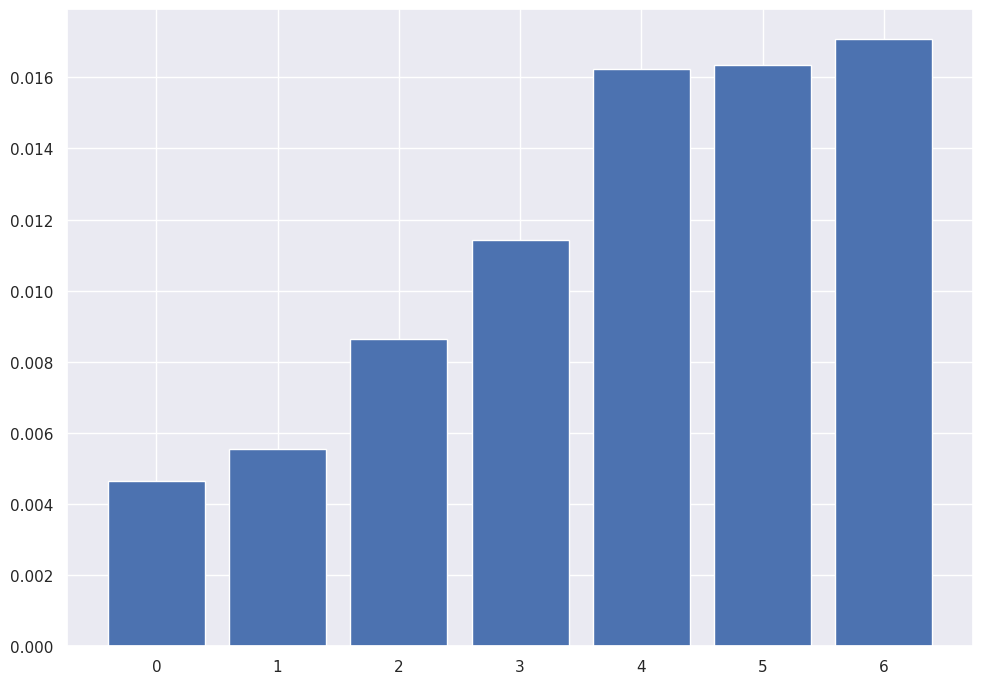

In [47]:
importance = results_final.importances_mean
importance=np.sort(importance)
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: {}  Score: {}' .format(i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))] ,importance)
plt.show()

- Com o dataframe balanceado

In [48]:
results_final_rs = permutation_importance(rfc3, X_train_rs.to_numpy(), y_train_rs.to_numpy(), scoring='accuracy')

Feature: 0  Score: 0.15591604669448983
Feature: 1  Score: 0.16275086191253854
Feature: 2  Score: 0.23837174136575334
Feature: 3  Score: 0.3145224702110929
Feature: 4  Score: 0.4050541341559305
Feature: 5  Score: 0.42844008951793383
Feature: 6  Score: 0.44921792778080205


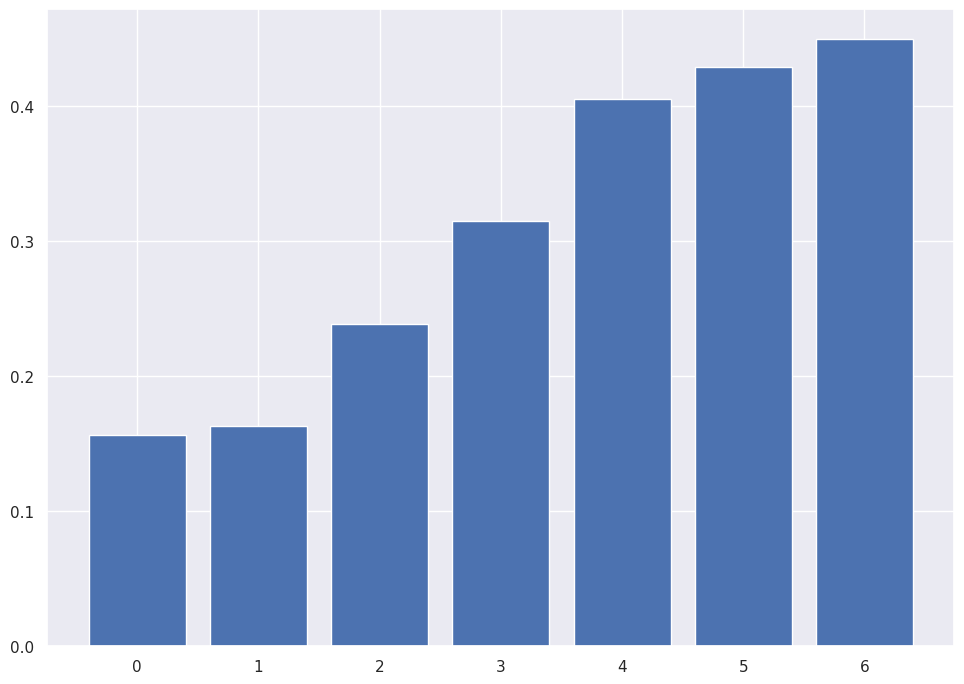

In [49]:
importance = results_final_rs.importances_mean
importance=np.sort(importance)
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: {}  Score: {}' .format(i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))] ,importance)
plt.show()

## 9) Comparação de métricas do modelo treinado com dados balanceados e não balanceados

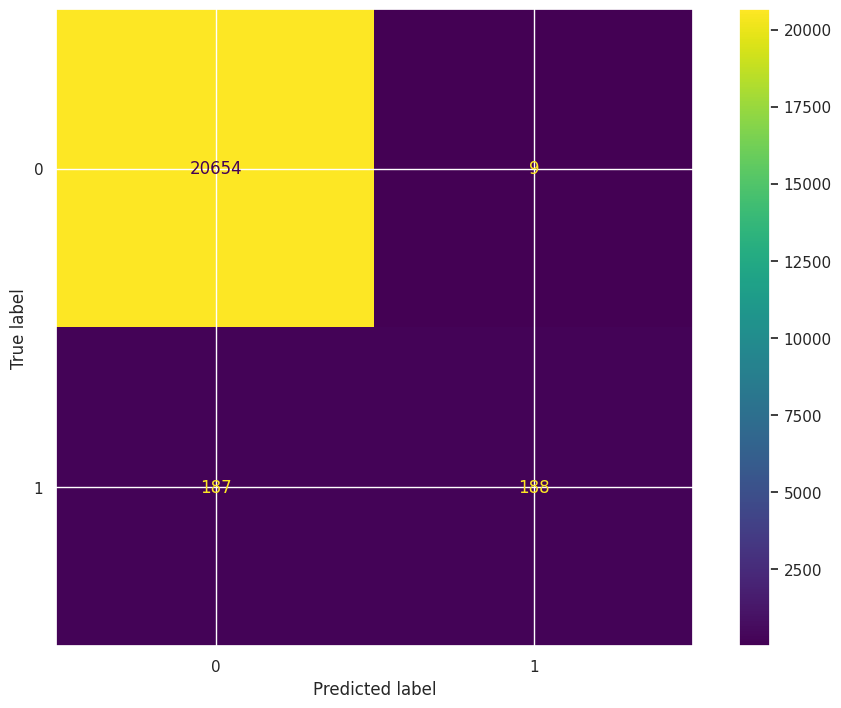

In [50]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred)).plot()

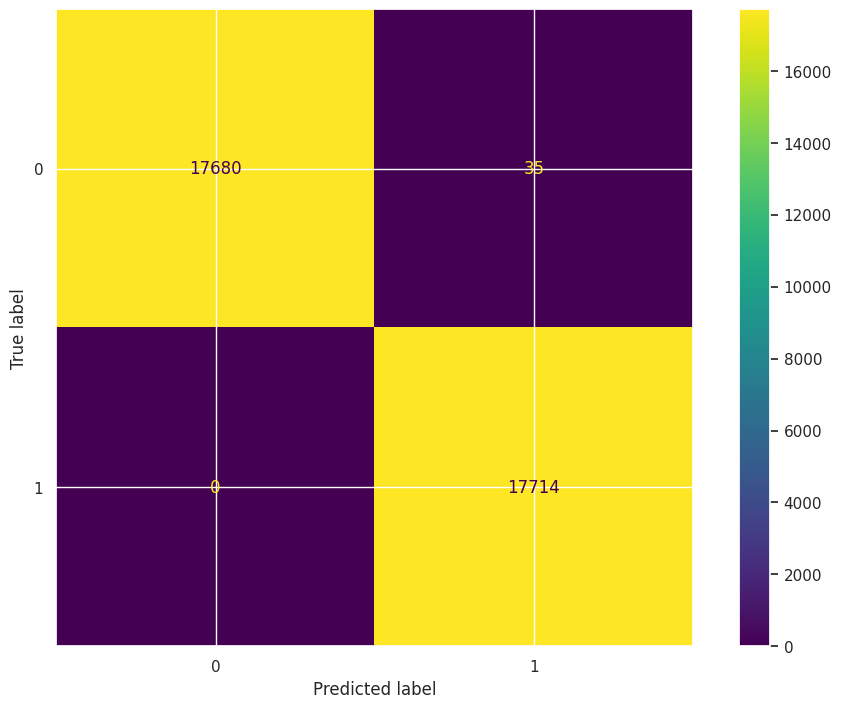

In [51]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test_rs, y_pred_rs)).plot()

## 10) Conclusão 


- Balancear os dados ajuda na explicabilidade dos resultados encontrados pelo modelo;
- Faz com que o modelo possa estimar melhor a classe minoritária.